# T-test: congruent vs. incongruent distances

In [1]:
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.reset_defaults()
sns.set_style("whitegrid") #  {darkgrid, whitegrid, dark, white, ticks}
sns.set_context("talk")

In [2]:
def load_results(results_fn, rep_name):
    """
        Function to load the results
            - result_fn: the path to the result folder
            - rep_name: what type of representation to use (e.g, the averaged representations)
    """
    results_dir = '../results/'
    results_path = os.path.join(results_dir,results_fn)
    
    with open(results_path, 'rb') as f:
        data = pickle.load(f)
    
    # Get regression results
    analysis = data['analysis']
    t_statistics = []
    p_values = []
    for run in analysis:
        t_statistics.append([s['ttest'][rep_name]['t_statistic'] for s in run])
        p_values.append([s['ttest'][rep_name]['p_value'] for s in run])
    t_statistics = np.array(t_statistics)
    p_values = np.array(p_values)
    
    # Get congruent vs. incongruent accuracy results
    results = data['results']
    cong_accs = []
    incong_accs = []
    for run in results:
        cong_accs.append([s['cong_acc'] for s in run['train_accs']])
        incong_accs.append([s['incong_acc'] for s in run['train_accs']])
    cong_accs = np.mean(cong_accs, axis=0)
    incong_accs = np.mean(incong_accs, axis=0)
    acc_ratios = incong_accs/cong_accs
    return t_statistics, p_values, acc_ratios

In [3]:
def plot_ttest(t_statistics, p_values, acc_ratios, title, save_fn):
    """
        Function to plot the results
            - t_statistics: t-values 
            - p_values: p-values corresponding to the t-values
            - acc_ratios: the ration of incongruent over the congruent accuracies
            - title: title for the plot
            - save_fn: filename to save the result
    """
    n_checkpoints = len(acc_ratios)
    fig, ax = plt.subplots(figsize=(20,6))
    
    # T statistics
    ax = sns.boxplot(data=t_statistics, color='tab:blue')
    ax = sns.stripplot(data=t_statistics, color='tab:blue')
    ax.axhline(y=1.96, color='r', linewidth=2)
    ax.axhline(y=-1.96, color='r', linewidth=2)
    ax.set_xticklabels([i*analyze_every for i in range(n_checkpoints)])
    ax.set_xlabel("Steps")
    ax.set_ylabel("T statistic")
    ax.set_title("{}: congruent vs. incongruent distances".format(title))
    
    # Accuracy ratio
    ax2 = ax.twinx()
    ax2 = sns.lineplot(data=acc_ratios, err_style="bars", markers=True, dashes=False, palette=['darkblue'])
    ax.set_title("Warping vs. accuracy")
    ax2.legend(["Accuracy Ratio"])
    ax2.set_ylim([-1, 3])
    ax2.set_ylabel("Ratio (incongruent / congruent)")

    # Save
    if save_fn is not None:
        plt.savefig(save_fn, dpi=300, bbox_inches='tight')
    
    plt.show()

Loading the results 

In [4]:
results_fn = 'rnn.P'
rep_name = 'average'
# steps at each we do the analysis (e.g, do the analysis every 50 steps)
analyze_every = 50 
title = "RNN"
save_fn = '../figures/ttest_rnn.eps'

In [5]:
t_statistics, p_values, acc_ratios = load_results(results_fn, rep_name)

Plotting the t-stat results

- each dot shows one run 
- the two horizontal lines define the levels of significancy:
        points with t-values > 2  & t_values < -2 are significant 

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


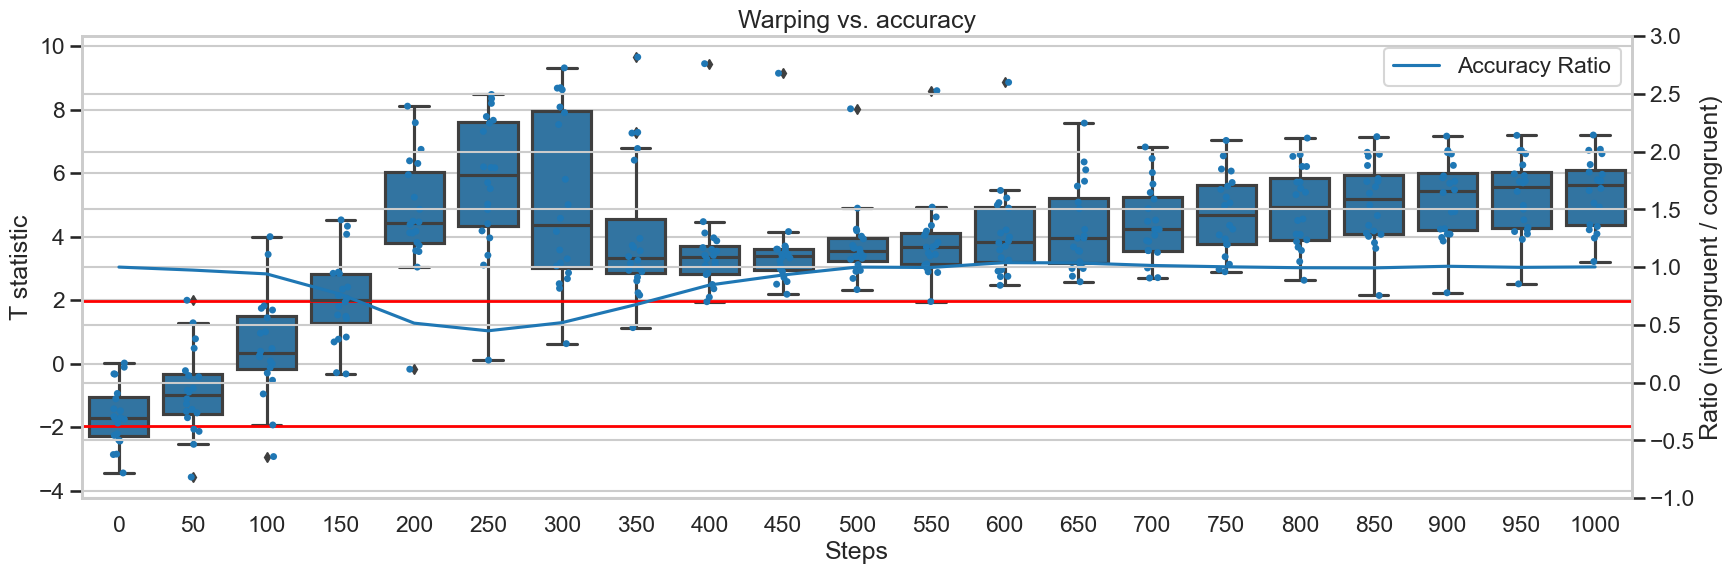

In [6]:
plot_ttest(t_statistics, p_values, acc_ratios, title, save_fn)

Save the results of the plots to a tsv file 

In [7]:
header = '\t'.join([f"Step{analyze_every*i}" for i in range(t_statistics.shape[1])])
np.savetxt('../results/tsv/ttest_tvalue_rnn.tsv', t_statistics, 
           delimiter='\t', header=header)
np.savetxt('../results/tsv/ttest_pvalue_rnn.tsv', p_values, 
           delimiter='\t', header=header)

Get stats for peak and final time step

In [8]:
median_t = np.median(t_statistics, axis=0)
median_p = np.median(p_values, axis=0)
peak_step = np.argmax(median_t)
peak_t = median_t[peak_step]
peak_p = median_p[peak_step]
final_t = median_t[-1]
final_p = median_p[-1]
print("Peak step:", peak_step*analyze_every, "Peak t:", peak_t, "Peak p:", peak_p)
print("Final t:", final_t, "Final p:", final_p)

Peak step: 250 Peak t: 5.9320911632605435 Peak p: 1.5212348812549753e-07
Final t: 5.633355976378642 Final p: 3.804134217687974e-07
